In [7]:
from tensorflow import keras
from keras import layers, activations, utils

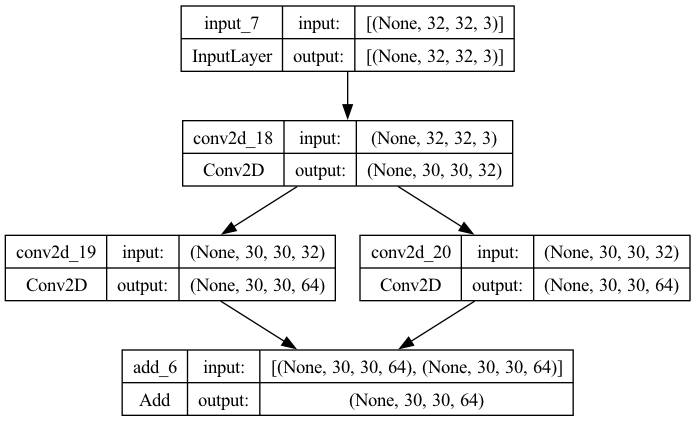

In [9]:
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation=activations.relu)(inputs)
residual = x

x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
residual = layers.Conv2D(filters=64, kernel_size=1)(residual)
x = layers.add([x, residual])

model = keras.Model(inputs=inputs, outputs=x)
utils.plot_model(model, show_shapes=True)

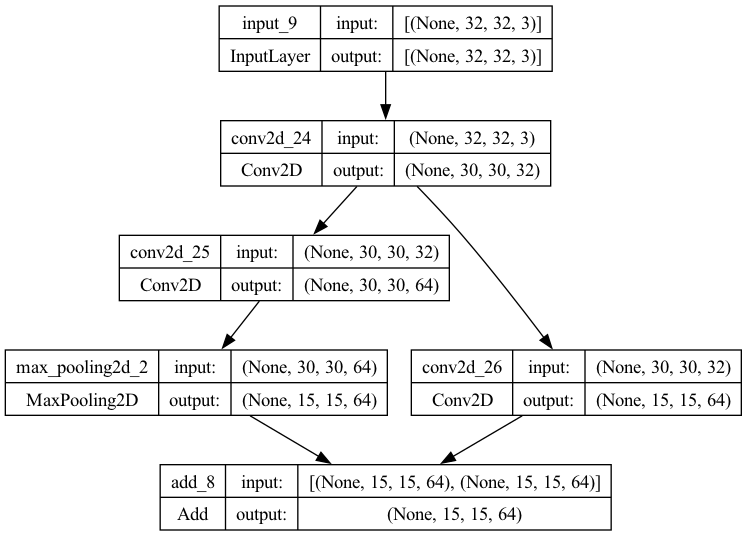

In [11]:
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation=activations.relu)(inputs)
residual = x

x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
x = layers.MaxPool2D(pool_size=2, padding='same')(x)
residual = layers.Conv2D(filters=64, kernel_size=1, strides=2, padding='same')(residual)
x = layers.add([x, residual])

model = keras.Model(inputs=inputs, outputs=x)
utils.plot_model(model, show_shapes=True)

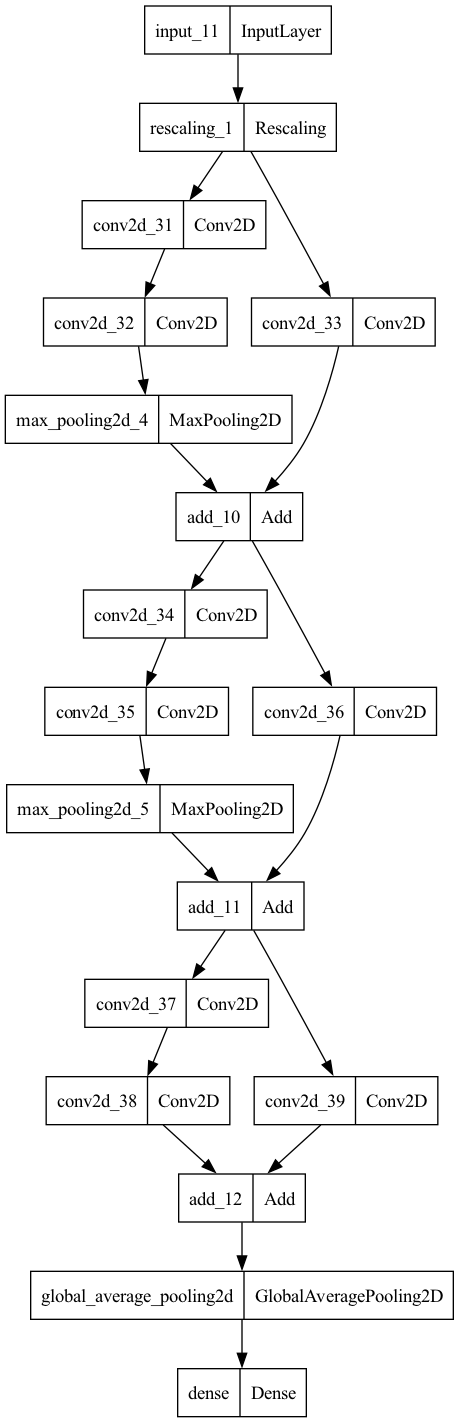

In [13]:
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters=filters, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=filters, kernel_size=3, activation=activations.relu, padding='same')(x)

    if pooling:
        x = layers.MaxPool2D(pool_size=2, padding='same')(x)
        residual = layers.Conv2D(filters=filters, kernel_size=1, strides=2, padding='same')(residual)
    else:
        residual = layers.Conv2D(filters=filters, kernel_size=1)(residual)
    
    x = layers.add([x, residual])
    return x

inputs = layers.Input(shape=(32, 32, 3))
x = layers.Rescaling(1 / 255)(inputs)
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation=activations.sigmoid)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
utils.plot_model(model)